# Patch Datasets Creation

Creating a dataset (will be later split for training and testing), with a patch segmentation of the echogram inspired by *Choi et al. 2021*. The rest is inspired by the *Matecho* echogram visualization tool by IRD (*Perrot et al. 2018*).

The idea is to split the echogram into 32x32 square patches.

Method:

* Create a `"data/"` folder to store the patches. (*to be modified when using annotations*)

* Retrieve `Sv_surface` data from the `Echointegration.mat` files of the *ABRAÇOS1* campaign (Acoustics along the BRAzilian COaSt, 2015) and turn it into CHW `torch.Tensor()`.

* Apply a threshold of (-80., -50.) dB: all values below -80dB (resp. above -50dB) will be assigned the value -80dB (resp. -50dB).

* Extract fixed and small-sized patches from the data. Each extracted patch consists of 32 × 32 × freqs pixels, with **2 criteria in order to avoid potential sources of bias**: 
    * **Overlap** between patches is not allowed.
    * Extracting location of a patch should be determined with **stochasticity**:
        1. Lay out grid points spacing 36 × 36.
        2. Each grid point becomes the center of the window for the patch extraction, randomly shifted within a range of [−2, 2] pixels to both width and height axes. (*should be done at the same time on the data and the annotation file*)
        

* Turn into `torch.utils.data.Dataset`


Dataset variations:
* `Epi_data`: shallower waters, all frequencies, no discontinuity.
* `Meso_shallow_data`: mid-depth waters, no 200kHz (out of range), no discontinuity.
* `Meso_deep_data`: deeper warters, 200kHz and 120kHz out of range, no discontinuity.
* `Complete_data`: all depths, all frequencies, discontinuities when frequencies reach end of range.

| Dataset Name | Depth Range (m) | Frequencies (kHz) |
| --- | --- | --- |
| `Epi_data` | 0 - ~250 | (200, 120, 70, 38) |
| `Meso_shallow_data` | ~300 - ~450 | (120, 70, 38) |
| `Meso_deep_data` | ~500 - 745 | (70, 38) |
| `Complete_data` | 0 - 745 | (200, 120, 70, 38) |

So far, we only focus on patches. Another possibility is to cut "slices" of a given width and spanning the whole depth. This should help take into account more geometrical features in the data.

## 0. Getting setup & Retrieving data

In [1]:
# Imports

import os
from pathlib import Path
import zipfile
import requests
import h5py

import math
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torchvision

### 0.1 Creating folders

In [2]:
# Setting up working directory
os.chdir("C:\\Users\\Gaspard\\Desktop\\Etudes\\L'X\\Stage 3A - MARBEC\\Data\\ABRACOS1\\EI002_High_resolution")
print(f"Current working directory: {os.getcwd()}")

# Creating folders
data_path = Path("data/")
epi_path = data_path / "Epi_data"
meso_shallow_path = data_path / "Meso_Shallow_data"
meso_deep_path = data_path / "Meso_Deep_data"
complete_path = data_path / "Complete_data"

data_path_dict = {"Epi_data" : epi_path,
                  "Meso_Shallow_data" : meso_shallow_path,
                  "Meso_Deep_data" : meso_deep_path,
                  "Complete_data" : complete_path}

for (key, path) in data_path_dict.items():
    if path.is_dir():
        print(f"{path} directory already exists.")
    else:
        print(f"Did not find {path} directory, creating one.")
        path.mkdir(parents=True, exist_ok=True)

Current working directory: C:\Users\Gaspard\Desktop\Etudes\L'X\Stage 3A - MARBEC\Data\ABRACOS1\EI002_High_resolution
data\Epi_data directory already exists.
data\Meso_Shallow_data directory already exists.
data\Meso_Deep_data directory already exists.
data\Complete_data directory already exists.


### 0.2 Retrieving data from the *ABRAÇOS1* `Echointegration.mat` file

In [3]:
# Retrieving .mat data with h5py.File (scipy.io.loadmat doesn't work on v7.3 files)
EI = h5py.File('Echointegration.mat','r')
print(EI)

# Turning into torch.Tensor()
Sv_surface_array = np.array(EI.get("Sv_surface"))
Sv_surface_tensor = torch.from_numpy(Sv_surface_array)
print(f"Old Sv_surface shape: {Sv_surface_tensor.shape} -> [color_channels (4), width, height] (CWH)")

# Reshaping to CHW
Sv_surface_tensor = Sv_surface_tensor.permute(0, 2, 1)
print(f"New shape: {Sv_surface_tensor.shape} -> CHW")

<HDF5 file "Echointegration.mat" (mode r)>
Old Sv_surface shape: torch.Size([4, 415019, 745]) -> [color_channels (4), width, height] (CWH)
New shape: torch.Size([4, 745, 415019]) -> CHW


## 1. Preprocessing data

### 1.1 Applying the threshold

In [4]:
# Defining thresholding function

def ApplyThresholds(x:torch.Tensor(), low:float, high:float=None):
    """Applies a threshold on a CHW tensor by limiting values to a minimum (low) and a maximum (high). 
    Also assigns NaN values to low. Leaves input tensor untouched and returns a new tensor.
    
    Args:
        x (torch.Tensor()): a CHW image format tensor.
        low (float): the minimum value to which any value below will be assigned. Defaults to None.
        high (float)(optional): the maximum value to which any value above will be assigned. Defaults to None.
    """
    color_channels, height, width = len(x[:, 0, 0]), len(x[0, :, 0]), len(x[0, 0, :])
    x_new = torch.zeros((color_channels, height, width))
    for c in range(color_channels):
        for h in range(height):
             for w in range(width):
                    if math.isnan(x[c, h, w]) or x[c, h, w] < low:
                        x_new[c, h, w] = low
                    elif high and x[c, h, w] > high:
                        x_new[c, h, w] = high
                    else:
                        x_new[c, h, w] = x[c, h, w]
    return x_new

In [7]:
LOW, HIGH = -80., -50.
#
#Sv_thresholded = ApplyThresholds(Sv_surface_tensor, LOW, HIGH)

Thresholding all the data at once is too much calculation (5min and counting...). Thresholds could be applyed to the small 32x32x4 patches. Let's create a smaller tensor to be able to test our code.

In [8]:
# Crop the top left corner
HEIGHT = 745
WIDTH = 1000

Sv_crop = Sv_surface_tensor[:4, :HEIGHT, :WIDTH]
Sv_crop_thresholded = ApplyThresholds(Sv_crop, LOW, HIGH)

In [9]:
print(f"Sv_crop hape: {Sv_crop_thresholded.shape} -> CHW")
print(f"Min value: {Sv_crop_thresholded.min()} | Max value: {Sv_crop_thresholded.max()}")

Sv_crop hape: torch.Size([4, 745, 1000]) -> CHW
Min value: -80.0 | Max value: -50.0


### 1.2 Creating random 36x36 grid

In [10]:
def layoutRandomGrid(img: torch.Tensor(), 
                     patch_height: int = 36, 
                     patch_width: int = 36,
                     shift: int = 0,
                     offset: tuple = (0, 0, 0, 0)):
    """Creates a grid layout for a CHW tensor, with rectangular patches of given dimensions.
    
    Args:
        x (torch.Tensor()): the CHW image tensor on which we the grid should be laid out.
        patch_height (int)(optional): the height of the patches. Defaults to 36.
        patch_width (int)(optional): the width of the patches. Defaults to 36.
        shit (int)(optional): range of the random shift applied to each center. Defaults to 0.
        offset (tuple)(optional): the distance to keep between the edges of the grid and those of the image. Is read (top, bottom, left, right). Defaults to (0, 0, 0, 0). 
    """
    height, width = len(img[0, :, 0]), len(img[0, 0, :])
    k_vertical = (height - offset[0] - offset[1]) // patch_height
    k_horizontal = (width - offset[1] - offset[3]) // patch_width
    
    Layout_Grid = np.array([[(0, 0)]*k_horizontal]*k_vertical)
    
    for i in range(k_vertical):
        y = offset[0] + int(patch_height*(i + 1/2))
        for j in range(k_horizontal):
            x = offset[2] + int(patch_width*(j + 1/2))
            Layout_Grid[i, j] = np.array([x + random.randint(-shift, shift), y + random.randint(-shift, shift)])
    
    return np.transpose(Layout_Grid, (2, 0, 1))

### 1.3 Visualizing grid

In [11]:
from shapely.geometry import LineString, Point, box

def plot_grid(Centers, dx:int = 32, dy:int=32):
    for i in range(len(Centers[0])):
        for j in range(len(Centers[0, 0])):
            x = Centers[0, i, j]
            y = Centers[1, i, j]
            box_loc = box(x-dx//2,
                          y-dy//2,
                          x+dx//2,
                          y+dy//2)
            plt.plot(*box_loc.exterior.xy, c="gray")

In [12]:
# Visualizing function

def plot_echogram_with_contrast(x):
    Sv_image = np.array(x.permute(1, 2, 0)).astype(int)
    # Get brightness range - i.e. darkest and lightest pixels
    min=np.min(Sv_image)
    max=np.max(Sv_image)

    # Make a LUT (Look-Up Table) to translate image values
    LUT=np.zeros(256,dtype=np.uint8)
    LUT[min:max+1]=np.linspace(start=0,stop=255,num=(max-min)+1,endpoint=True,dtype=np.uint8)

    Sv_image_contrasted = LUT[Sv_image]
    plt.figure(figsize=(10, 10))
    plt.imshow(Sv_image_contrasted)

    plt.title(f"Top left corner of the echogram, size = {WIDTH}x{HEIGHT}")

Centers matrix shape: (2, 3, 4)


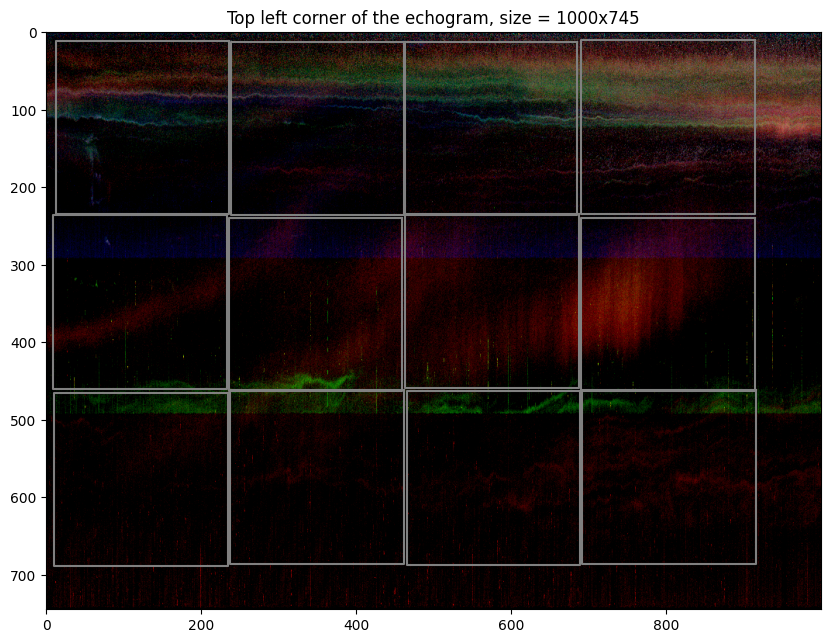

In [14]:
# Let's plot the echogram and the grid at the same time

plot_echogram_with_contrast(Sv_crop_thresholded[:3, :, :])
Centers = layoutRandomGrid(Sv_crop_thresholded,
                     patch_height=226,
                     patch_width=226,
                     shift=2,
                     offset=(10, 10, 10, 10))
print(f"Centers matrix shape: {Centers.shape}")
plot_grid(Centers,
         dx=224,
         dy=224) 

### 1.4 Copying patches into folders